# PHAS0030 Assignment Week 7

A Molecular Dynamics simulation of Lennard-Jones model of Neon using Velocity-Verlet for propagation with an initial cubic structure.

In [42]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1. Set up the force function

You might want a comment...

In [43]:
def find_forces_LJ(pos,N,sigma,epsilon,boxlen):
    """Evaluate the force due to Lennard-Jones potential and energy of the system
    
    Inputs:
    pos            Position (Npart x 3 array) of all the particle 
    N              Number of particles
    sigma,epsilon  LJ parameters
    boxlen         Lnegth of simulation cell
    
    
    Outputs:
    Energy         LJ Energy 
    Force          Forces on particles (Npart x 3 array)
    """
    
    force = np.zeros((N,3))
    energy = 0.0
    sigma6 = sigma**6
    sigma12 = sigma6*sigma6
    
    for i in range(N-1):
        for j in range(i+1,N):
            dr = pos[j] - pos[i]
            # Adjustment to distance between particle due to periodic boudaries
            dr -=boxlen*np.rint(dr/boxlen)
            dr2 = np.sum(dr*dr)
            dr2i = 1.0/dr2
            dr6i = dr2i*dr2i*dr2i
            fij  = 24.0*epsilon*dr*dr2i*dr6i* (sigma6 -2.0*sigma12*dr6i)
            force[i] +=fij
            force[j] -=fij
            energy += 4.0*epsilon*dr6i*(sigma12*dr6i - sigma6)
    return energy, force



### 2. Set up the lattice and the simulation parameters



In [44]:

# Initialisation
Nsteps =  10000  #'''Change to 10,000 later!!!!!'''
kB = 1.38e-23         # J/K
sigma =  0.275e-9      # 0.275nm
epsilon = 36*kB       # 36kT
mass = 20.2*1.673e-27 # kg

Ncells = 3
boxlen = Ncells*2**(1/6)*sigma *1.1
Npart = Ncells*Ncells*Ncells
rbox3 = np.zeros([Nsteps,Npart,3])
vbox3 = np.zeros([Nsteps,Npart,3])
count = 0

for i in range(Ncells):
    for j in range(Ncells):
        for k in range(Ncells):
            rbox3[0,count] = (1.0/Ncells)*boxlen*np.array([i,j,k])
            count += 1



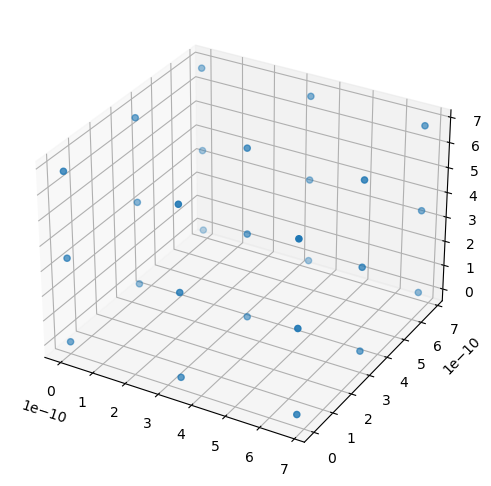

In [45]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter(rbox3[0,:,0],rbox3[0,:,1],rbox3[0,:,2])
    

### 3. Initialise velocities

In [46]:
def periodic(r_3,L_3):
    r_periodic= np.mod(r_3,L_3)
    return r_periodic

# Initialise velocities
initT  = 50          # K
# The initial distribution can have an arbitrary scaling
rng=np.random.default_rng()
vbox3[0] = rng.standard_normal(size=(Npart,3))
# These line rescales the velocities
v_scale = np.sqrt(3*Npart*kB*initT/(mass*np.sum(vbox3[0]*vbox3[0])))
vbox3[0] *= v_scale
energy = np.zeros(Nsteps)
temp = np.zeros(Nsteps)
e, f = find_forces_LJ(rbox3[0],Npart,sigma,epsilon,boxlen)
energy[0] = e
temp[0] = mass*np.sum(vbox3[0]*vbox3[0])/(3*Npart*kB)
acc = f/mass
dt = 1e-15 # s 
MSD = np.zeros(Nsteps-1)
MSD_6t=np.zeros(Nsteps-1)


### 4. Run simulation


In [86]:
for step in range(1,Nsteps):
    rbox3[step] = rbox3[step-1] + dt*vbox3[step-1] + 0.5*dt*dt*acc # acc at step-1
    # Periodic boundaries
    rbox3[step]=periodic(rbox3[step],boxlen)
    energy[step], f = find_forces_LJ(rbox3[step],Npart,sigma,epsilon,boxlen)
    acc_next = f/mass
    vbox3[step] = vbox3[step-1] + 0.5*dt*(acc_next + acc)
    temp[step] = mass*np.sum(vbox3[step]*vbox3[step])/(3*Npart*kB)
    acc = acc_next
    
    # Calculate mean-squared displacement
    displacement=(rbox3[step-1]-rbox3[0])
    MSD[step-1] = np.sum(displacement**2)   # Not normalised Yet
    MSD_6t [step-1]=np.sum((displacement**2)) /((6*step-1)*dt)
# Normalisation of MSD
MSD /= Npart 
MSD_6t /= Npart


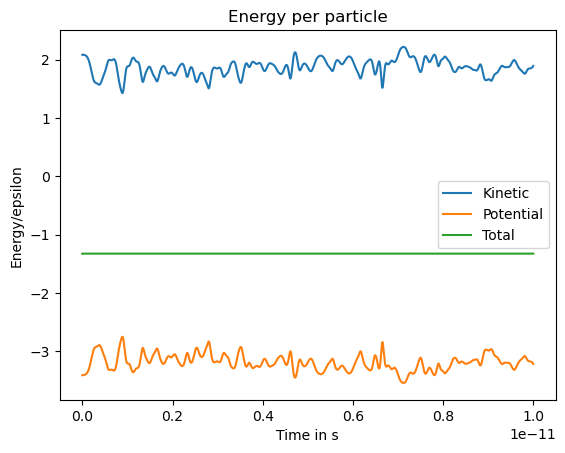

In [88]:
timeaxis = np.linspace(0,Nsteps*dt - dt,Nsteps)
ke = 0.5*mass*np.sum(vbox3*vbox3,axis=(1,2))
plt.plot(timeaxis,ke/(Npart*epsilon),label='Kinetic')
plt.plot(timeaxis,energy/(Npart*epsilon),label='Potential')
plt.plot(timeaxis,(ke+energy)/(Npart*epsilon),label='Total')
plt.title("Energy per particle")
plt.xlabel("Time in s")
plt.ylabel("Energy/epsilon")
plt.legend()

## Energy of the system
Total energy of the system conserved while potential and kinetic energy fluctuates.

Text(0.5, 0, 'time (s)')

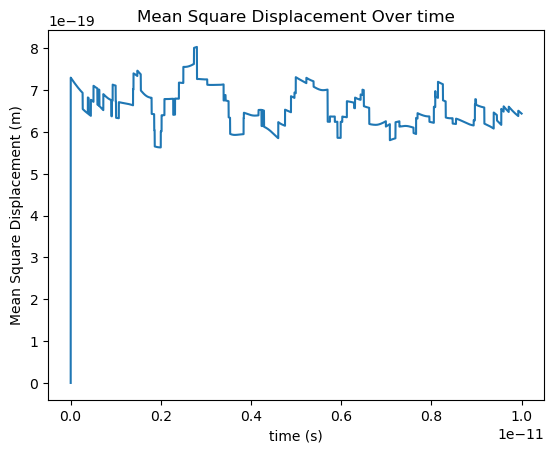

In [89]:

time = dt*np.arange(1,Nsteps)
plt.plot(time ,MSD)
plt.title('Mean Square Displacement Over time')
plt.ylabel('Mean Square Displacement (m)')
plt.xlabel('time (s)')

The Mean squared displacement divide by 6t is converging to 1.0735614519154524e-08


Text(0.5, 0, 'time (s)')

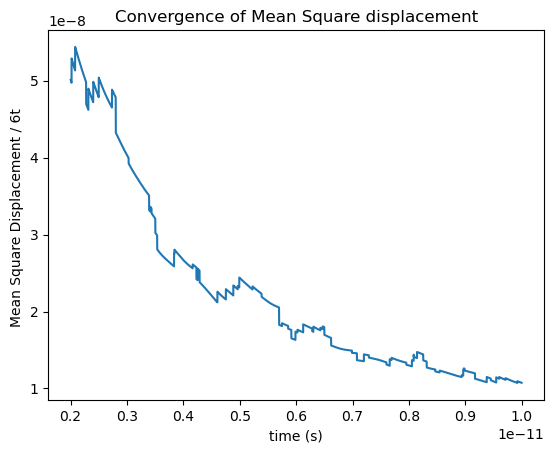

In [90]:
time_2=dt*np.arange(2001,Nsteps)
plt.plot(time_2,MSD_6t[2000:])
print(f'The Mean squared displacement divide by 6t is converging to {MSD_6t[-1]}')
plt.title('Convergence of Mean Square displacement')
plt.ylabel('Mean Square Displacement / 6t ')
plt.xlabel('time (s)')

### 5. Calculate the integral

[0.00000000e+00 2.04174631e-11 4.08441176e-11 ... 2.66701740e-08
 2.66730508e-08 2.66759340e-08]


Text(0.5, 0, 'time (s)')

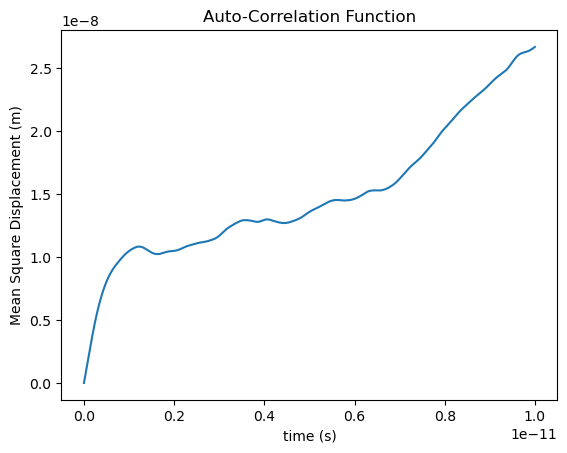

In [91]:
Int = np.zeros(Nsteps)
for step in range(1,Nsteps):
    Int[step] = Int[step-1] + np.sum(vbox3[step-1]*vbox3[0])*dt

#Normalisation 1/3N
Int /= 3*Npart
time = dt*np.arange(0,Nsteps)
print(Int)

plt.plot(time,Int)
plt.title('Auto-Correlation Function')
plt.ylabel('Mean Square Displacement (m)')
plt.xlabel('time (s)')

## Conclusion
Did not manage to conserve any convergent on the mean square displacement, maybe I have calculated the wrong MSD.